In [ ]:
import sys
import math
import requests
import numpy as np
import pandas as pd
from io import StringIO, BytesIO
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.manifold import SpectralEmbedding
from sklearn.manifold import Isomap
from scipy.stats import ttest_ind

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/arrhythmia/"
file_name = "arrhythmia.data"
description = "arrhythmia.names"
r = requests.get(url + file_name, allow_redirects=True)

In [ ]:
with open("arrhythmia.data", "wb") as f:
  f.write(r.content)

In [ ]:
with open("arrhythmia.data", "rb") as f:
  content = f.read()
data = BytesIO(content)
# see data set info for what the values are
header = range(1, 281)
df = pd.read_csv(data, names=header)
print(df)

     1    2    3    4    5    6    7    ...  274  275  276  277   278   279 280
0     75    0  190   80   91  193  371  ...  0.0  0.0  0.9  2.9  23.3  49.4   8
1     56    1  165   64   81  174  401  ...  0.0  0.0  0.2  2.1  20.4  38.8   6
2     54    0  172   95  138  163  386  ...  0.0  0.0  0.3  3.4  12.3  49.0  10
3     55    0  175   94  100  202  380  ...  0.0  0.0  0.4  2.6  34.6  61.6   1
4     75    0  190   80   88  181  360  ...  0.0  0.0 -0.1  3.9  25.4  62.8   7
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...  ..
447   53    1  160   70   80  199  382  ...  0.0  0.0  0.7  0.6  -4.4  -0.5   1
448   37    0  190   85  100  137  361  ...  0.0  0.0  0.4  2.4  38.0  62.4  10
449   36    0  166   68  108  176  365  ...  0.0  0.0  1.5  1.0 -44.2 -33.2   2
450   32    1  155   55   93  106  386  ...  0.0  0.0  0.5  2.4  25.0  46.6   1
451   78    1  160   70   79  127  364  ...  0.0  0.0  0.5  1.6  21.3  32.8   1

[452 rows x 280 columns]


**Data Preparation** 

After loading in the dataset, we want to remove or impute the values we cannot work with (e.g., NA, inappropriate data types)

In [ ]:
# check the datatypes for each column
df.dtypes

1        int64
2        int64
3        int64
4        int64
5        int64
        ...   
276    float64
277    float64
278    float64
279    float64
280      int64
Length: 280, dtype: object

In [ ]:
# check the number of NAs in each row
df.isna().sum()

1      0
2      0
3      0
4      0
5      0
      ..
276    0
277    0
278    0
279    0
280    0
Length: 280, dtype: int64

Seems impressive that there are no NAs present in the data. However, there seem to be non-numerical values present in the data (i.e., ca, thal).  

Taking another glance at the data, it seems like missing data are denoted with a '?'. Let's count how many ? are present in the dataset

In [ ]:
(df.values == "?").sum()

408

There are four values in *ca* that are marked with a '?'. Let's impute these values with the mean

In [ ]:
# convert ? to nans and fill in nans with the median
df = df.replace("?", np.nan)
df = df.fillna(df.median())

# convert each columns to the right types
df = df.apply(pd.to_numeric)

# sanity check that all ? values are removed
# all ? values are removed
(df.values == "?")
# ensure all columns solely contain numeric ones
(df.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())).sum() == len(df.dtypes)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # Remove the CWD from sys.path while we load stuff.


True

In [ ]:
# check to see if everything has been converted
df.dtypes

1        int64
2        int64
3        int64
4        int64
5        int64
        ...   
276    float64
277    float64
278    float64
279    float64
280      int64
Length: 280, dtype: object

Seems like the data is now processed!

**Exploratory Data Analysis**

Before we dive into the clustering and the algorithms, let's understand the data that we'll be working with! 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Columns: 280 entries, 1 to 280
dtypes: float64(125), int64(155)
memory usage: 988.9 KB


In [ ]:
# distribution of different labels
df[280].value_counts()

1     245
10     50
2      44
6      25
16     22
4      15
3      15
5      13
9       9
15      5
14      4
7       3
8       2
Name: 280, dtype: int64

# Split Train Test

In [ ]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=.25, random_state=42, stratify=df[280])

In [ ]:
train_set

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280
359,54,0,160,70,98,169,290,163,86,49,-144.0,28.0,61.0,-162.0,101.0,12,44,0,0,0,36,0,0,0,0,0,0,0,76,0,0,0,28,0,0,0,0,0,0,36,...,0.0,21.1,-14.9,0.0,0.0,0.6,1.0,1.7,11.3,-1.7,0.0,11.6,0.0,0.0,0.0,0.4,-1.8,27.8,13.8,-1.5,0.0,7.9,0.0,0.0,0.0,0.4,-1.3,28.4,18.3,-1.1,0.0,6.8,0.0,0.0,0.0,0.3,-0.8,24.4,18.2,2
307,53,0,171,79,80,169,363,135,83,1,11.0,41.0,3.0,-50.5,50.0,20,72,0,0,0,44,0,0,0,0,0,0,0,72,0,0,0,24,0,0,0,0,0,0,48,...,0.0,10.9,-4.9,0.0,0.0,0.4,4.9,14.1,55.2,-0.4,-0.4,16.1,-1.2,0.0,0.0,0.5,3.0,33.0,52.8,-0.1,-0.5,10.7,0.0,0.0,0.0,0.4,1.7,35.7,45.5,0.0,-0.4,6.3,0.0,0.0,0.0,0.4,1.0,23.5,29.1,6
78,56,1,165,73,90,147,388,178,92,88,68.0,75.0,82.0,-50.5,65.0,0,48,44,0,0,32,0,0,0,0,0,0,24,48,0,0,0,48,0,0,0,0,0,0,32,...,0.0,3.6,-14.1,0.0,0.0,0.5,2.9,-33.0,-4.0,-0.2,0.0,7.3,-7.9,0.0,0.0,1.3,2.2,-6.1,11.9,-0.9,-0.4,13.4,-4.7,0.0,0.0,1.3,2.3,18.0,41.4,-1.0,-0.5,14.8,-2.4,0.0,0.0,1.4,2.4,26.8,51.2,1
228,36,0,170,85,84,139,363,184,82,2,8.0,-2.0,4.0,-50.5,62.0,0,48,36,0,0,24,0,0,0,0,0,0,0,44,44,0,0,28,0,0,0,0,0,0,76,...,0.0,8.0,-8.8,0.0,0.0,1.1,7.1,-0.1,82.2,0.0,0.0,11.1,-5.5,0.0,0.0,0.6,3.4,10.1,39.3,-0.2,0.0,10.3,-2.7,0.0,0.0,0.4,2.7,16.2,39.4,-0.2,0.0,7.8,-0.8,0.0,0.0,0.3,1.7,15.4,30.0,1
234,46,1,165,83,89,180,412,198,108,78,63.0,57.0,73.0,-50.5,74.0,0,44,40,0,0,28,0,0,0,0,0,0,20,56,0,0,0,48,0,0,0,0,0,0,28,...,0.0,18.7,-8.7,0.0,0.0,0.5,7.9,44.0,134.0,0.2,0.0,18.7,-3.0,0.0,0.0,1.0,4.9,48.7,95.7,0.1,-0.4,17.9,-1.3,0.0,0.0,0.9,3.9,45.0,80.8,0.0,-0.7,15.4,-0.5,0.0,0.0,0.9,3.1,38.6,66.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,59,0,165,74,92,158,388,163,104,-1,3.0,46.0,0.0,-50.5,65.0,24,68,0,0,0,44,0,0,0,0,0,0,24,44,32,0,0,44,0,0,0,0,0,0,0,...,-1.0,17.6,-7.8,0.0,0.0,-0.5,5.1,18.6,62.4,-0.7,-1.3,14.2,-4.0,0.0,0.0,0.6,4.1,15.2,51.2,-0.4,-1.1,9.9,-1.3,0.0,0.0,0.6,3.1,18.1,44.7,-0.1,-0.9,6.2,0.0,0.0,0.0,0.6,2.2,14.9,34.7,1
117,28,1,159,56,96,153,340,152,90,-16,19.0,17.0,1.0,-50.5,86.0,24,36,40,0,0,40,0,0,0,0,0,0,0,56,44,0,0,32,0,0,0,0,0,0,0,...,0.0,8.2,-4.1,0.0,0.0,0.5,3.5,17.3,49.5,-0.2,0.0,3.3,-2.5,0.0,0.0,0.5,1.4,1.5,11.3,0.0,0.0,3.5,-2.0,0.0,0.0,0.5,1.7,2.8,14.7,0.0,0.0,3.1,-1.8,0.0,0.0,0.6,1.6,1.8,13.0,1
215,30,1,160,65,79,131,360,140,77,3,36.0,13.0,21.0,-50.5,79.0,0,44,16,0,0,24,0,0,0,0,0,0,0,40,24,0,0,24,0,0,0,0,0,0,0,...,0.0,6.2,-7.8,0.0,0.0,0.5,3.1,2.4,27.2,0.1,0.0,8.3,-6.3,0.0,0.0,0.5,2.6,6.6,26.3,0.1,0.0,7.6,-3.6,0.0,0.0,0.3,2.3,10.9,28.3,0.1,0.0,6.8,-2.1,0.0,0.0,0.1,2.2,11.1,27.8,1
441,37,1,160,50,74,143,374,146,75,68,14.0,49.0,55.0,-50.5,65.0,0,48,20,0,0,24,0,0,0,0,0,0,0,60,16,0,0,36,0,0,0,0,0,0,0,...,0.0,7.2,-2.3,0.0,0.0,0.6,4.9,18.9,63.9,0.0,0.0,17.6,-2.5,0.0,0.0,0.7,2.9,57.3,82.2,-0.1,0.0,16.6,-1.9,0.0,0.0,0.7,2.4,54.5,75.1,0.0,0.0,11.4,-0.9,0.0,0.0,0.7,1.8,40.1,55.5,1


In [ ]:
test_set

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280
110,71,1,162,72,82,294,366,148,178,-12,13.0,45.0,-4.0,-50.5,68.0,0,56,0,0,0,20,0,0,0,0,0,0,0,48,44,0,0,32,0,0,0,0,0,0,0,...,0.0,10.2,-6.7,0.0,0.0,-0.2,4.2,7.0,43.9,-0.3,0.0,7.1,-6.1,0.0,0.0,-0.6,3.3,2.2,29.9,-0.6,0.0,10.3,-2.3,0.0,0.0,-0.4,1.7,20.6,32.1,-0.6,0.0,9.5,0.0,0.0,0.0,-0.3,1.3,24.7,35.6,1
101,39,1,155,59,91,171,387,117,93,73,60.0,53.0,71.0,-50.5,63.0,20,44,0,0,0,36,0,0,0,0,0,0,24,68,0,0,0,44,0,0,0,0,0,0,24,...,0.0,6.9,0.0,0.0,0.0,0.6,2.2,30.3,62.8,0.0,-1.6,22.9,0.0,0.0,0.0,0.9,0.5,103.4,106.7,-0.1,-2.0,16.7,0.0,0.0,0.0,0.7,1.0,57.3,63.9,-0.1,-1.7,13.0,0.0,0.0,0.0,0.7,0.9,47.4,53.3,1
216,17,1,156,40,77,106,465,147,57,53,174.0,67.0,84.0,-50.5,89.0,0,56,0,0,0,28,0,0,0,0,0,0,0,60,0,0,0,32,0,0,0,0,0,0,0,...,0.0,2.6,-12.0,0.0,0.0,-0.3,1.1,-19.9,-3.2,-0.7,0.0,13.2,-5.2,0.0,0.0,0.4,-1.3,18.6,3.6,-1.2,-1.0,17.0,-2.1,0.0,0.0,0.9,-2.1,37.1,12.8,-0.8,-0.8,12.6,-1.3,0.0,0.0,1.0,-1.7,27.9,8.2,2
151,32,0,173,75,111,171,347,235,94,24,18.0,58.0,21.0,-50.5,74.0,0,52,28,0,0,28,0,0,0,0,0,0,0,48,44,0,0,32,0,0,0,0,0,0,0,...,0.0,9.1,-13.4,0.0,0.0,-1.0,9.9,-12.1,112.6,0.5,0.0,18.1,-9.1,0.0,0.0,0.2,7.0,36.1,113.1,0.1,0.0,15.1,-5.1,0.0,0.0,0.1,4.1,27.0,72.1,0.0,0.0,9.9,-2.5,0.0,0.0,0.1,2.4,17.2,43.6,1
376,67,0,163,78,106,173,365,196,82,-73,108.0,31.0,-80.0,116.0,69.0,0,48,0,0,0,16,0,0,0,0,0,0,0,36,60,0,0,24,0,0,0,0,0,0,0,...,0.0,3.7,-13.2,0.0,0.0,0.6,1.8,-34.1,-19.7,0.6,0.0,6.4,-14.4,0.0,0.0,0.8,1.4,-32.0,-16.9,0.7,0.0,5.9,-10.5,0.0,0.0,0.6,1.2,-18.6,-5.0,0.5,0.0,4.2,-6.4,0.0,0.0,0.4,0.8,-12.0,-2.1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,64,1,160,80,62,160,376,136,104,4,52.0,5.0,15.0,-50.5,68.0,0,60,0,0,0,32,0,0,0,0,0,0,0,68,0,0,0,20,0,0,0,0,0,0,52,...,0.0,6.8,-2.4,0.0,0.0,0.9,2.8,13.8,38.4,-0.4,0.0,6.2,-1.0,0.0,0.0,0.5,1.5,13.6,24.7,-0.4,0.0,6.8,0.0,0.0,0.0,0.5,1.4,19.0,29.3,0.0,0.0,5.5,0.0,0.0,0.0,0.4,1.1,19.8,27.2,1
296,59,1,160,72,97,149,363,251,82,-1,-174.0,21.0,-18.0,151.0,72.0,0,64,0,0,0,32,0,0,0,0,0,0,0,88,0,0,0,24,0,1,0,0,0,0,52,...,0.0,26.9,-13.2,0.0,0.0,1.0,-5.1,43.7,-26.6,-1.0,0.0,14.2,-10.2,0.0,0.0,0.4,-3.7,5.5,-21.8,-1.3,0.0,11.6,0.0,0.0,0.0,0.3,-2.9,30.1,8.7,-0.8,0.0,8.9,0.0,0.0,0.0,0.3,-2.2,30.2,14.0,2
413,53,1,160,60,86,133,338,159,82,74,36.0,53.0,60.0,-50.5,80.0,0,40,40,0,0,24,0,0,0,0,0,0,12,84,0,0,0,32,0,1,0,0,0,0,20,...,0.0,15.1,-20.5,0.0,0.0,0.9,3.1,1.2,34.0,1.4,0.0,16.3,-18.2,0.0,0.0,1.2,3.6,6.4,40.2,0.1,0.0,12.4,-7.9,0.0,0.0,1.1,1.8,-3.6,10.4,0.0,-0.4,11.6,-5.3,0.0,0.0,1.0,2.1,0.5,17.3,1
230,72,0,171,74,77,172,330,140,104,33,42.0,51.0,36.0,-50.5,84.0,0,52,32,0,0,28,0,0,0,0,0,0,0,68,0,0,0,36,0,0,0,0,0,0,44,...,0.0,12.3,-6.8,0.0,0.0,0.2,1.0,18.9,29.5,0.1,0.0,9.2,-2.9,0.0,0.0,0.6,0.4,16.2,19.0,-0.2,0.0,8.3,-1.3,0.0,0.0,0.5,0.6,17.9,21.1,0.0,0.0,6.8,0.0,0.0,0.0,0.7,0.8,25.8,31.4,1


In [ ]:
df[280].value_counts() / len(df)
test_set[280].value_counts() / len(test_set)

1     0.539823
10    0.106195
2     0.097345
16    0.053097
6     0.053097
4     0.035398
3     0.035398
5     0.026549
9     0.017699
15    0.008850
14    0.008850
8     0.008850
7     0.008850
Name: 280, dtype: float64

In [ ]:
train_set[280].value_counts() / len(train_set)

1     0.542773
10    0.112094
2     0.097345
6     0.056047
16    0.047198
4     0.032448
3     0.032448
5     0.029499
9     0.020649
15    0.011799
14    0.008850
7     0.005900
8     0.002950
Name: 280, dtype: float64

# Data Normalization

In [ ]:
# create label
labels = df[280]
labelProbs = [0 for i in range(17)]
for i in range(len(labels)):
  labelProbs[int(labels[i])] += 1
for i in range(len(labelProbs)):
  labelProbs[i] = labelProbs[i]/452
# print(labelProbs)
feature_names = [i for i in range(5, 280)]

# create labels for train and test set
train_labels = train_set[280]
test_labels = test_set[280]

# dropping age, sex, height, weight and label
df = df.drop(columns=[1, 2, 3, 4, 280])
train_set = train_set.drop(columns=[1, 2, 3, 4, 280])
test_set = test_set.drop(columns=[1, 2, 3, 4, 280])

In [ ]:
print(labels)
print(df)
print(train_labels.shape)
print(train_set.shape)
print(test_labels.shape)
print(test_set.shape)

0       8
1       6
2      10
3       1
4       7
       ..
447     1
448    10
449     2
450     1
451     1
Name: 280, Length: 452, dtype: int64
     5    6    7    8    9    10    11   ...   273  274  275  276  277   278   279
0     91  193  371  174  121  -16  13.0  ...  -0.9  0.0  0.0  0.9  2.9  23.3  49.4
1     81  174  401  149   39   25  37.0  ...   0.0  0.0  0.0  0.2  2.1  20.4  38.8
2    138  163  386  185  102   96  34.0  ...  -2.4  0.0  0.0  0.3  3.4  12.3  49.0
3    100  202  380  179  143   28  11.0  ...  -2.2  0.0  0.0  0.4  2.6  34.6  61.6
4     88  181  360  177  103  -16  13.0  ...  -3.6  0.0  0.0 -0.1  3.9  25.4  62.8
..   ...  ...  ...  ...  ...  ...   ...  ...   ...  ...  ...  ...  ...   ...   ...
447   80  199  382  154  117  -37   4.0  ...  -5.0  0.0  0.0  0.7  0.6  -4.4  -0.5
448  100  137  361  201   73   86  66.0  ...  -1.6  0.0  0.0  0.4  2.4  38.0  62.4
449  108  176  365  194  116  -85 -19.0  ... -28.6  0.0  0.0  1.5  1.0 -44.2 -33.2
450   93  106  386  218

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# create scaler
scaler = MinMaxScaler()
# fit scaler on data
scaler.fit(df)
# apply transform
standardized = scaler.transform(df)

In [ ]:
# create scaler
scaler = MinMaxScaler()
# fit scaler on data
scaler.fit(train_set)
# apply transform
train_set = scaler.transform(train_set)

In [ ]:
# create scaler
scaler = MinMaxScaler()
# fit scaler on data
scaler.fit(test_set)
# apply transform
test_set = scaler.transform(test_set)

In [ ]:
print(standardized)
print(standardized.shape)

[[0.27067669 0.36832061 0.50180505 ... 0.74166667 0.5075188  0.56957929]
 [0.19548872 0.33206107 0.6101083  ... 0.675      0.48571429 0.50097087]
 [0.62406015 0.3110687  0.55595668 ... 0.78333333 0.42481203 0.56699029]
 ...
 [0.39849624 0.33587786 0.4801444  ... 0.58333333 0.         0.03495146]
 [0.28571429 0.20229008 0.55595668 ... 0.7        0.52030075 0.55145631]
 [0.18045113 0.24236641 0.4765343  ... 0.63333333 0.4924812  0.46213592]]
(452, 275)


In [ ]:
# cut out low variance
variance_arr = np.var(train_set, axis=0)
threshold = np.average(variance_arr)

filter_arr = variance_arr > threshold
print(filter_arr.shape)
train_set = train_set[:, filter_arr]
print(train_set.shape)

(275,)
(339, 116)


In [ ]:
# cut out in test for predicting purposes
test_set = test_set[:, filter_arr]
print(test_set.shape)

(113, 116)


In [ ]:
# cut out in all
standardized = standardized[:, filter_arr]
print(standardized.shape)

(452, 116)


Make Copies of Scaled Data + Train Data + Test Data

In [ ]:
standardized2 = standardized.copy()
train_set2 = train_set.copy()
test_set2 = test_set.copy()

**Playing Around with PCA**

Create a lower-dimension embedding, make a scree plot to see how low we should go for PCA





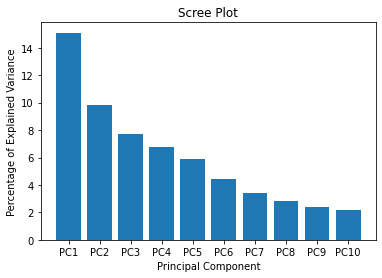

In [ ]:
def PCA_reduce(data, dims=10):
  pca = PCA(n_components=dims)
  pca.fit(data)
  reducedEmb = pca.transform(data)
  ### generate scree plot - only needed for determination of n_comps
  per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
  labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
  plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
  plt.ylabel('Percentage of Explained Variance')
  plt.xlabel('Principal Component')
  plt.title('Scree Plot')
  # plt.savefig('scree plot.png')
  return reducedEmb

PCA_data = PCA_reduce(standardized)


In [ ]:
def plotEmb(data, labels):
  colors = {1: "red",
            2: "sienna",
            3: "sandybrown",
            4: "tan",
            5: "moccasin",
            6: "gold",
            7: "olivedrab",
            8: "chartreuse",
            9: "darkgreen",
            10: "mediumspringgreen",
            11: "lightseagreen",
            12: "paleturquoise",
            13: "navy", 
            14: "blue",
            15: "plum",
            16: "m"}
  fig, ax = plt.subplots()
  ax.scatter(data[:,0], data[:,1], c=labels.map(colors), s=5, alpha=0.5)
  ax.set_xlabel("PC 1")
  ax.set_ylabel("PC 2")

def colorRef():
  colors = ["red",
            "sienna",
            "sandybrown",
            "tan",
            "moccasin",
            "gold",
            "olivedrab",
            "chartreuse",
            "darkgreen",
            "mediumspringgreen",
            "lightseagreen",
            "paleturquoise",
            "navy", 
            "blue",
            "plum",
            "m"]
  fig, ax = plt.subplots()
  X = [1 for i in range(16)]
  Y = [i for i in range(1, 17)]
  ax.scatter(X, Y, c=colors, s=5, alpha=0.5)

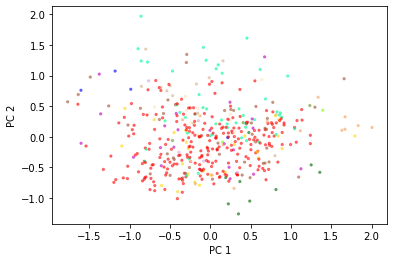

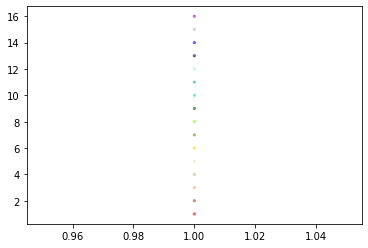

In [ ]:
plotEmb(PCA_data, labels)
colorRef()

#TSNE

In [ ]:
def TSNE_reduce(data, dims=2):
    tsne = TSNE(n_components=dims, perplexity = 150)
    reducedEmb = tsne.fit_transform(data)
    return reducedEmb

TSNE_data = TSNE_reduce(standardized, 3)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


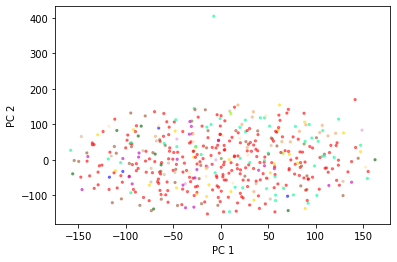

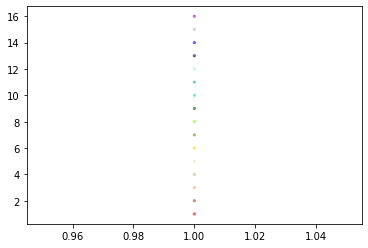

In [ ]:
plotEmb(TSNE_data, labels)
colorRef()

In [ ]:
def specEmb_reduce(data, dims=2): 
  specEmb = SpectralEmbedding(n_components=dims)
  reducedEmb = specEmb.fit_transform(data)
  return reducedEmb

spec_data = specEmb_reduce(standardized)

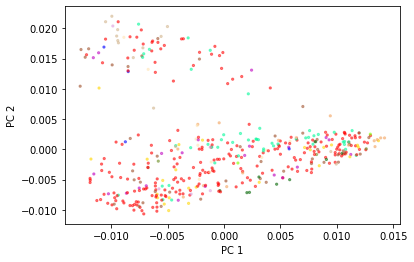

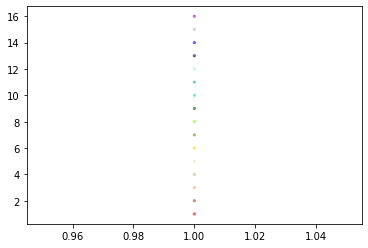

In [ ]:
plotEmb(spec_data, labels)
colorRef()

In [ ]:
def isomap_reduce(data, dims=2):
  isomap = Isomap(n_components=dims)
  reducedEmb = isomap.fit_transform(data)
  return reducedEmb

isomap_data = isomap_reduce(standardized)

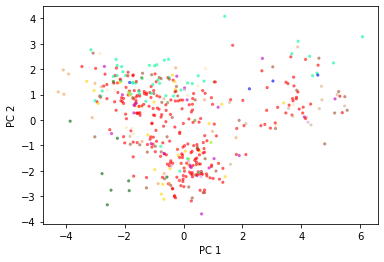

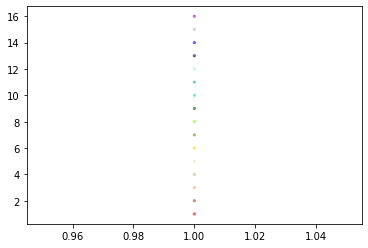

In [ ]:
plotEmb(isomap_data, labels)
colorRef()

**Feature Selection**: SFS

In [ ]:
classes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16]
class_names = ["Normal", 
               "Ischemic changes/CAD", 
               "Old Anterior MI", 
               "Old Inferior MI", 
               "Sinus tachycardy", 
               "Sinus bradycardy", 
               "Premature Ventricular Contraction", 
               "Premature Supraventricular Contraction", 
               "Left bundle branch block", 
               "Right bundle branch block", 
               "Left ventricular hypertrophy", 
               "Atrial Fib/Flutter",
               "Others"]

def print_top_de_features(matrix, class_labels, classes, class_names, feature_names, num_features = 5):
    num_classes = len(classes)
    ttest_results_all = np.zeros((num_classes, len(feature_names), 2))
    for class_i in classes: 
        this_class = matrix[class_labels == class_i]
        notthis_class = matrix[class_labels != class_i]
        for feature_i, feature in enumerate(feature_names):
            ttest = ttest_ind(this_class[:, feature_i], notthis_class[:, feature_i], equal_var = False, nan_policy='omit')
            ttest_results_all[classes.index(class_i), feature_i, :] = np.array([ttest[0], ttest[1]])
    for class_i in classes:
        print(class_names[classes.index(class_i)])
        max_ind = np.argsort(ttest_results_all[classes.index(class_i),:,1])
        print('Class {}, top {} "DE" features:'.format(class_i, num_features))
        for i in range(num_features):
            print(np.array(feature_names)[max_ind[i]])

## print_top_de_features(standardized, labels, classes, class_names, feature_names)
class1F5 = [199, 5, 169, 167, 197]
class2F5 = [267, 177, 277, 197, 217]
class3F5 = [222, 181, 40, 232, 93]
class4F5 = [64, 201, 76, 91, 279]
class5F5 = [55, 194, 103, 149, 15]
class6F5 = [15, 7, 8, 273, 194]
class7F5 = [42, 183, 64, 16, 28]
class8F5 = [77, 172, 246, 148, 16]
class9F5 = [18, 40, 163, 148, 16]
class10F5 = [57, 91, 93, 30, 150]
class14F5 = [64, 16, 161, 88, 201]
class15F5 = [9, 6, 78, 42, 213]
class16F5 = [43, 184, 83, 118, 31]

classesF5 = [class1F5, class2F5, class3F5, class4F5, class5F5,
             class6F5, class7F5, class8F5, class9F5, class10F5,
             class14F5, class15F5, class16F5]

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
sfs = SequentialFeatureSelector(RandomForestClassifier(), n_features_to_select=10)
sfs.fit(standardized, labels)
np.nonzero(sfs.get_support() == True)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selecti

(array([ 4,  6,  7, 38, 45, 46, 47, 54, 58, 76]),)

Here is what the selected features stand for✈ (will wait and see)

*   2 - Sex
*   6 - P-R interval: Average duration between onset of P and Q waves in msec.
*   66 - AVL Channel
*   88, 89, 92 - V1 Channel
*   100 - V2 Channel
*   117 - V3 Channel
*   159 - V6 Channel
*   200 - AVL Channel

In [ ]:
standardized = sfs.transform(standardized)
standardized.shape

(452, 10)

In [ ]:
train_set = sfs.transform(train_set)
train_set.shape

(339, 10)

In [ ]:
test_set = sfs.transform(test_set)
test_set.shape

(113, 10)

#ML

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


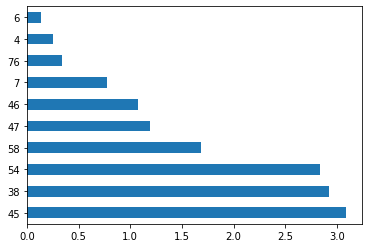

In [ ]:
from sklearn.svm import SVC
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

clf = make_pipeline(MinMaxScaler(), SVC(gamma='auto'))
clf.fit(train_set, train_labels)
#print(labels.tolist())
predicted_labels_svm = clf.predict(test_set)
classifier = OneVsRestClassifier(
    SVC(kernel="linear", probability=True)
)
classifier.fit(train_set, train_labels)
predicted_prob_svm = classifier.predict_proba(test_set)
#print(predicted_labels)

idxs = np.ndarray.tolist(np.nonzero(sfs.get_support() == True)[0])
pd.Series(abs(classifier.coef_[0]), index=idxs).nlargest(10).plot(kind='barh')

In [ ]:
cross_val_score(clf, standardized, labels, cv=10, scoring='accuracy').mean()

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  UserWarning,


0.6215458937198068

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(train_set, train_labels) # 45 is about 10% of 452
predicted_labels_rf = clf.predict(test_set)
# 10-Fold Cross validation
print(np.mean(cross_val_score(clf, standardized, labels, cv=10)))

classifier = OneVsRestClassifier(
    RandomForestClassifier()
)
classifier.fit(train_set, train_labels)
predicted_prob_rf = classifier.predict_proba(test_set)

from sklearn.inspection import permutation_importance
import time

start_time = time.time()
result = permutation_importance(
    clf, test_set, test_labels, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=idxs)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  UserWarning,


0.7519323671497584
Elapsed time to compute the importances: 2.307 seconds


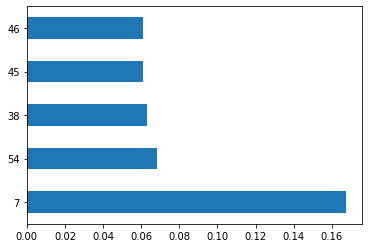

In [ ]:
forest_importances.nlargest(5).plot(kind='barh')

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(train_set, train_labels)
predicted_labels_knn = knn.predict(test_set)
print(cross_val_score(knn, standardized, labels, cv=10, scoring='accuracy').mean())

classifier = OneVsRestClassifier(
    KNeighborsClassifier()
)
classifier.fit(train_set, train_labels)
predicted_prob_knn = classifier.predict_proba(test_set)

start_time = time.time()
result = permutation_importance(
    knn, test_set, test_labels, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

knn_importances = pd.Series(result.importances_mean, index=idxs)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  UserWarning,


0.6879227053140097
Elapsed time to compute the importances: 0.361 seconds


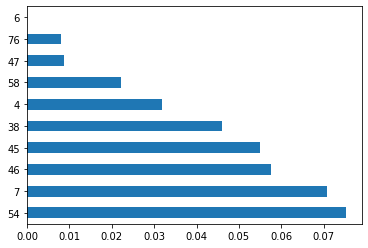

In [ ]:
knn_importances.nlargest(10).plot(kind='barh')

In [ ]:
from sklearn.naive_bayes import GaussianNB
clf_pf = GaussianNB()
clf_pf.fit(train_set, train_labels)
predicted_labels_gnb = clf_pf.predict(test_set)
print(cross_val_score(clf_pf, standardized, labels, cv=10, scoring='accuracy').mean())

classifier = OneVsRestClassifier(
    GaussianNB()
)
classifier.fit(train_set, train_labels)
predicted_prob_gnb = classifier.predict_proba(test_set)

start_time = time.time()
result = permutation_importance(
    clf_pf, test_set, test_labels, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

nb_importances = pd.Series(result.importances_mean, index=idxs)

0.1303864734299517
Elapsed time to compute the importances: 0.085 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  UserWarning,


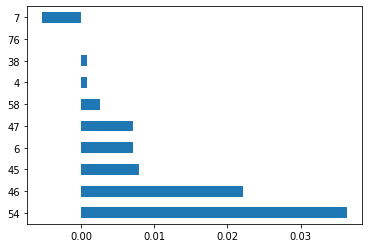

In [ ]:
nb_importances.nlargest(10).plot(kind='barh')

In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
      hidden_layer_sizes=(5, 2), random_state=1, max_iter=1000)
clf.fit(train_set, train_labels) # 45 is about 10% of 452
predicted_labels_NN = clf.predict(test_set)
print(cross_val_score(clf, standardized, labels, cv=10, scoring='accuracy').mean())

classifier = OneVsRestClassifier(
    MLPClassifier(solver='lbfgs', alpha=1e-5,
      hidden_layer_sizes=(5, 2), random_state=1, max_iter=1000)
)
classifier.fit(train_set, train_labels)
predicted_prob_NN = classifier.predict_proba(test_set)

start_time = time.time()
result = permutation_importance(
    clf, test_set, test_labels, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

mlp_importances = pd.Series(result.importances_mean, index=idxs)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


0.6414975845410629
Elapsed time to compute the importances: 0.068 seconds


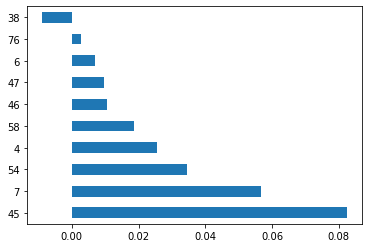

In [ ]:
mlp_importances.nlargest(10).plot(kind='barh')

In [ ]:
print(test_labels.shape)
print(predicted_prob_rf.shape)
print(len(np.unique(test_labels))) # should be 13
print(np.unique(test_labels))

(113,)
(113, 13)
13
[ 1  2  3  4  5  6  7  8  9 10 14 15 16]


# ROC AUC

SVM

In [ ]:
macro_roc_auc_ovo_svm = roc_auc_score(test_labels, predicted_prob_svm, multi_class="ovo", average="macro")
weighted_roc_auc_ovo_svm = roc_auc_score(test_labels, predicted_prob_svm, multi_class="ovo", average="weighted")

In [ ]:
macro_roc_auc_ovr_svm = roc_auc_score(test_labels, predicted_prob_svm, multi_class="ovr", average="macro")
weighted_roc_auc_ovr_svm = roc_auc_score(test_labels, predicted_prob_svm, multi_class="ovr", average="weighted")

In [ ]:
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo_svm, weighted_roc_auc_ovo_svm)
)

print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr_svm, weighted_roc_auc_ovr_svm)
)

One-vs-One ROC AUC scores:
0.782620 (macro),
0.788631 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.724224 (macro),
0.816801 (weighted by prevalence)


Random Forest

In [ ]:
macro_roc_auc_ovo_rf = roc_auc_score(test_labels, predicted_prob_rf, multi_class="ovo", average="macro")
weighted_roc_auc_ovo_rf = roc_auc_score(test_labels, predicted_prob_rf, multi_class="ovo", average="weighted")

In [ ]:
macro_roc_auc_ovr_rf = roc_auc_score(test_labels, predicted_prob_rf, multi_class="ovr", average="macro")
weighted_roc_auc_ovr_rf = roc_auc_score(test_labels, predicted_prob_rf, multi_class="ovr", average="weighted")

In [ ]:
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo_rf, weighted_roc_auc_ovo_rf)
)

print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr_rf, weighted_roc_auc_ovr_rf)
)

One-vs-One ROC AUC scores:
0.799944 (macro),
0.844804 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.822932 (macro),
0.871882 (weighted by prevalence)


KNN

In [ ]:
macro_roc_auc_ovo_knn = roc_auc_score(test_labels, predicted_prob_knn, multi_class="ovo", average="macro")
weighted_roc_auc_ovo_knn = roc_auc_score(test_labels, predicted_prob_knn, multi_class="ovo", average="weighted")

In [ ]:
macro_roc_auc_ovr_knn = roc_auc_score(test_labels, predicted_prob_knn, multi_class="ovr", average="macro")
weighted_roc_auc_ovr_knn = roc_auc_score(test_labels, predicted_prob_knn, multi_class="ovr", average="weighted")

In [ ]:
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo_knn, weighted_roc_auc_ovo_knn)
)

print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr_knn, weighted_roc_auc_ovr_knn)
)

One-vs-One ROC AUC scores:
0.759114 (macro),
0.803908 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.774539 (macro),
0.818664 (weighted by prevalence)


Naive Bayes

In [ ]:
# macro_roc_auc_ovo_gnb = roc_auc_score(test_labels, predicted_prob_gnb, multi_class="ovo", average="macro")
# weighted_roc_auc_ovo_gnb = roc_auc_score(test_labels, predicted_prob_gnb, multi_class="ovo", average="weighted")

In [ ]:
# macro_roc_auc_ovr_gnb = roc_auc_score(test_labels, predicted_prob_gnb, multi_class="ovr", average="macro")
# weighted_roc_auc_ovr_gnb = roc_auc_score(test_labels, predicted_prob_gnb, multi_class="ovr", average="weighted")

In [ ]:
# print(
#     "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
#     "(weighted by prevalence)".format(macro_roc_auc_ovo_gnb, weighted_roc_auc_ovo_gnb)
# )

# print(
#     "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
#     "(weighted by prevalence)".format(macro_roc_auc_ovr_gnb, weighted_roc_auc_ovr_gnb)
# )

Neural Network

In [ ]:
macro_roc_auc_ovo_NN = roc_auc_score(test_labels, predicted_prob_NN, multi_class="ovo", average="macro")
weighted_roc_auc_ovo_NN = roc_auc_score(test_labels, predicted_prob_NN, multi_class="ovo", average="weighted")

In [ ]:
macro_roc_auc_ovr_NN = roc_auc_score(test_labels, predicted_prob_NN, multi_class="ovr", average="macro")
weighted_roc_auc_ovr_NN = roc_auc_score(test_labels, predicted_prob_NN, multi_class="ovr", average="weighted")

In [ ]:
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo_NN, weighted_roc_auc_ovo_NN)
)

print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr_NN, weighted_roc_auc_ovr_NN)
)

One-vs-One ROC AUC scores:
0.727331 (macro),
0.714077 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.642464 (macro),
0.707418 (weighted by prevalence)


### No Feature Selection

Support Vector Machines

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


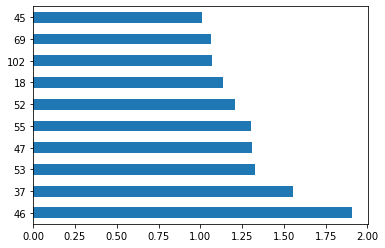

In [ ]:
clf = make_pipeline(MinMaxScaler(), SVC(gamma='auto'))
clf.fit(train_set2, train_labels)
#print(labels.tolist())
predicted_labels_svm = clf.predict(test_set2)
classifier = OneVsRestClassifier(
    SVC(kernel="linear", probability=True)
)
classifier.fit(train_set2, train_labels)
predicted_prob_svm = classifier.predict_proba(test_set2)
#print(predicted_labels)

idxs = list(range(1, 116+1))
pd.Series(abs(classifier.coef_[0]), index=idxs).nlargest(10).plot(kind='barh')

In [ ]:
cross_val_score(clf, standardized2, labels, cv=10, scoring='accuracy').mean()

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  UserWarning,


0.5420289855072464

Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(train_set2, train_labels) # 45 is about 10% of 452
predicted_labels_rf = clf.predict(test_set2)
# 10-Fold Cross validation
print(np.mean(cross_val_score(clf, standardized2, labels, cv=10)))

classifier = OneVsRestClassifier(
    RandomForestClassifier()
)
classifier.fit(train_set2, train_labels)
predicted_prob_rf = classifier.predict_proba(test_set2)

from sklearn.inspection import permutation_importance
import time

start_time = time.time()
result = permutation_importance(
    clf, test_set2, test_labels, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=idxs)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  UserWarning,


0.7432850241545894
Elapsed time to compute the importances: 15.058 seconds


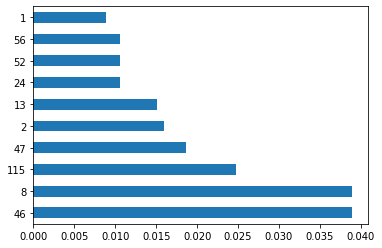

In [ ]:
forest_importances.nlargest(10).plot(kind='barh')

K Nearest Neighbors 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(train_set2, train_labels)
predicted_labels_knn = knn.predict(test_set2)
print(cross_val_score(knn, standardized2, labels, cv=10, scoring='accuracy').mean())

classifier = OneVsRestClassifier(
    KNeighborsClassifier()
)
classifier.fit(train_set2, train_labels)
predicted_prob_knn = classifier.predict_proba(test_set2)

start_time = time.time()
result = permutation_importance(
    knn, test_set2, test_labels, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

knn_importances = pd.Series(result.importances_mean, index=idxs)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  UserWarning,


0.6017874396135265
Elapsed time to compute the importances: 4.249 seconds


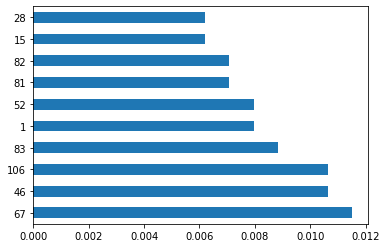

In [ ]:
knn_importances.nlargest(10).plot(kind='barh')

MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
      hidden_layer_sizes=(5, 2), random_state=1, max_iter=1000)
clf.fit(train_set2, train_labels) # 45 is about 10% of 452
predicted_labels_NN = clf.predict(test_set2)
print(cross_val_score(clf, standardized2, labels, cv=10, scoring='accuracy').mean())

classifier = OneVsRestClassifier(
    MLPClassifier(solver='lbfgs', alpha=1e-5,
      hidden_layer_sizes=(5, 2), random_state=1, max_iter=1000)
)
classifier.fit(train_set2, train_labels)
predicted_prob_NN = classifier.predict_proba(test_set2)

start_time = time.time()
result = permutation_importance(
    clf, test_set2, test_labels, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

mlp_importances = pd.Series(result.importances_mean, index=idxs)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  UserWarning,


0.5420289855072464
Elapsed time to compute the importances: 0.534 seconds


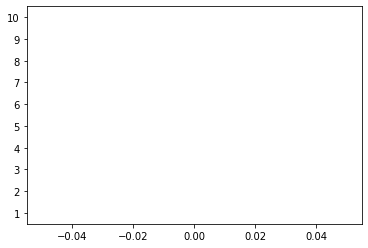

In [ ]:
mlp_importances.nlargest(10).plot(kind='barh')

## ROC AUC for no feature selection

SVM

In [ ]:
macro_roc_auc_ovo_svm = roc_auc_score(test_labels, predicted_prob_svm, multi_class="ovo", average="macro")
weighted_roc_auc_ovo_svm = roc_auc_score(test_labels, predicted_prob_svm, multi_class="ovo", average="weighted")

In [ ]:
macro_roc_auc_ovr_svm = roc_auc_score(test_labels, predicted_prob_svm, multi_class="ovr", average="macro")
weighted_roc_auc_ovr_svm = roc_auc_score(test_labels, predicted_prob_svm, multi_class="ovr", average="weighted")

In [ ]:
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo_svm, weighted_roc_auc_ovo_svm)
)

print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr_svm, weighted_roc_auc_ovr_svm)
)

One-vs-One ROC AUC scores:
0.772918 (macro),
0.817761 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.783221 (macro),
0.855018 (weighted by prevalence)


Random Forest

In [ ]:
macro_roc_auc_ovo_rf = roc_auc_score(test_labels, predicted_prob_rf, multi_class="ovo", average="macro")
weighted_roc_auc_ovo_rf = roc_auc_score(test_labels, predicted_prob_rf, multi_class="ovo", average="weighted")

In [ ]:
macro_roc_auc_ovr_rf = roc_auc_score(test_labels, predicted_prob_rf, multi_class="ovr", average="macro")
weighted_roc_auc_ovr_rf = roc_auc_score(test_labels, predicted_prob_rf, multi_class="ovr", average="weighted")

In [ ]:
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo_rf, weighted_roc_auc_ovo_rf)
)

print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr_rf, weighted_roc_auc_ovr_rf)
)

One-vs-One ROC AUC scores:
0.851968 (macro),
0.868706 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.860828 (macro),
0.870478 (weighted by prevalence)


KNN

In [ ]:
macro_roc_auc_ovo_knn = roc_auc_score(test_labels, predicted_prob_knn, multi_class="ovo", average="macro")
weighted_roc_auc_ovo_knn = roc_auc_score(test_labels, predicted_prob_knn, multi_class="ovo", average="weighted")

In [ ]:
macro_roc_auc_ovr_knn = roc_auc_score(test_labels, predicted_prob_knn, multi_class="ovr", average="macro")
weighted_roc_auc_ovr_knn = roc_auc_score(test_labels, predicted_prob_knn, multi_class="ovr", average="weighted")

In [ ]:
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo_knn, weighted_roc_auc_ovo_knn)
)

print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr_knn, weighted_roc_auc_ovr_knn)
)

One-vs-One ROC AUC scores:
0.724906 (macro),
0.715155 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.725373 (macro),
0.669192 (weighted by prevalence)


Neural Network

In [ ]:
macro_roc_auc_ovo_NN = roc_auc_score(test_labels, predicted_prob_NN, multi_class="ovo", average="macro")
weighted_roc_auc_ovo_NN = roc_auc_score(test_labels, predicted_prob_NN, multi_class="ovo", average="weighted")

In [ ]:
macro_roc_auc_ovr_NN = roc_auc_score(test_labels, predicted_prob_NN, multi_class="ovr", average="macro")
weighted_roc_auc_ovr_NN = roc_auc_score(test_labels, predicted_prob_NN, multi_class="ovr", average="weighted")

In [ ]:
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo_NN, weighted_roc_auc_ovo_NN)
)

print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr_NN, weighted_roc_auc_ovr_NN)
)

One-vs-One ROC AUC scores:
0.500000 (macro),
0.500000 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.500000 (macro),
0.500000 (weighted by prevalence)
